In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from utilities.utilities import df_stats, df_changes
import glob
import pgeocode

## Data Extraction

The data are split over several csv files. Here we load the date into a single dataframe.

First, let's print the structure of the csv files in the folder data/

In [2]:
files = [i for i in glob.glob('data/ka-feedback-*.csv')]
csv_columns = [pd.read_csv(f).columns for f in files]
for i,cols in enumerate(csv_columns):
    print("file {}: {}".format(i+1," ".join(cols)))

file 1: Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal
file 2: Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal
file 3: Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal
file 4: Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal
file 5: Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal
file 6: Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal
file 7: Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal
file 8: Vorgangsnnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal


Some observations and suggestions:  
1. Each file has the same columns $\Rightarrow$ Concatenate dataframes  
2. There are two date columns $\Rightarrow$ Parse dates  
3. Typo in the first column in the last file $\Rightarrow$ Translate column name  

Concerning date parsing, two different time zones are used in the data:  
- CET = UTC + 1  (winter time)  
- CEST = UTC + 2  (summer time)   

but neither of these time zones are in place at the same time of the year.

Example:

In [3]:
one = pd.read_csv(files[1], parse_dates=['Erstellungsdatum'])
print(one['Erstellungsdatum'][0], " -> winter time")
print(one['Erstellungsdatum'][1300], " -> summer time")

2013-12-31 18:46:00+01:00  -> winter time
2013-07-28 17:59:00+02:00  -> summer time


In order to compare winter and summer results, will be best to strip the timezone information.

Example:

In [4]:
one = pd.read_csv(files[1], parse_dates=['Erstellungsdatum'],
                  date_parser=lambda col: pd.to_datetime(col).tz_localize(None))
print(one['Erstellungsdatum'][0], " -> local time")
print(one['Erstellungsdatum'][1300], " -> local time")

2013-12-31 18:46:00  -> local time
2013-07-28 17:59:00  -> local time


Following all the suggestions above, here we load all data into a dataframe.

In [5]:
# Load data from csv files into dataframe
def read_csv(file):
    """Read csv and parse dates"""
    df = pd.read_csv(file, 
                     parse_dates=['Erstellungsdatum','Letztes Bearbeitungsdatum'],
                     date_parser=lambda col: pd.to_datetime(col).tz_localize(None)
                    )
    # Fix typo in column name
    df = df.rename(columns={'Vorgangsnnummer':'Vorgangsnummer'})
    return df

# Concat dataframes
df = pd.concat(map(read_csv, files), ignore_index=True)

# Optimize datatypes
df = df.convert_dtypes()

# Sort by Erstellungsdatum, as future entries will arrive in order of this quantity
df = df.sort_values('Erstellungsdatum', ignore_index=True)

# Print changes
print(df_changes(df,'ka',init=True))

Now tracking changes to dataframe (label='ka')
Added 58449 rows
Added 7 columns:
------------------------------------------------------------- 58449 x 7
                                    dtype   #NA  %NA  #unique
Kategorie                          string     0    0       24
Vorgangsnummer                     string     0    0    58445
Erstellungsdatum           datetime64[ns]     0    0    55397
Ort                                string  4069    6    24307
Zustand                            string     0    0        4
Eingangskanal                      string     0    0        3
Letztes Bearbeitungsdatum  datetime64[ns]     0    0    49693
-------------------------------------------------------------


## Initial Data Cleaning

As a next step, we'll perform initial data cleaning.

Let's start by showing the first few rows:

In [6]:
df.head(5)

,Vorgangsnummer,Kategorie,Ort,Zustand,Erstellungsdatum,Letztes Bearbeitungsdatum,Eingangskanal
0,3m6hno,Verkehrsverstöße,"Basler-Tor-Straße 29-30, 76227 Karlsruhe",Behoben,2012-02-24 22:16:00,2015-03-20 09:59:00,MOBILE
1,fsaeor,Verkehrsverstöße,"Gärtnerstraße 17, 76227 Karlsruhe",Behoben,2012-03-04 17:42:00,2015-03-20 10:00:00,MOBILE
2,blm3gf,Verkehrsverstöße,"Georg-Büchner-Straße 4, 76149 Karlsruhe",Behoben,2012-03-07 20:31:00,2015-03-20 10:00:00,MOBILE
3,2cfufu,Straßenbeleuchtung,"Stadtwerke, 76185 Karlsruhe",Abgeschlossen,2012-03-09 10:20:00,2017-01-11 13:28:00,MOBILE
4,riwctt,Verkehrsverstöße,"Henriette-Obermüller-Straße 10, 76137 Karlsruhe",Behoben,2012-03-11 17:22:00,2012-03-11 17:22:00,MOBILE


There are a few obvious cleaning actions that can be performed.

**Action 1:** Drop column `Vorgangsnummer`, which is a unique identifier without logical information.

In [7]:
df = df.drop('Vorgangsnummer', axis=1)
print(df_changes(df,'ka'))

Removed 1 column:
- Vorgangsnummer (string)


**Action 2:** Drop duplicate rows

In [8]:
df = df.drop_duplicates().reset_index(drop=True)
print(df_changes(df,'ka'))

Removed 569 rows


**Action 3:** Replace NA in `Ort` by '-' (for convenience in subsequent processing)

In [9]:
df = df.fillna(value={'Ort':'-'})
print(df_changes(df,'ka'))

Same rows and columns. Possibly updated values in cells.


## Data Analysis

After the initial data cleaning, the dataframe statistics are as follows:

In [10]:
print(df_stats(df))

------------------------------------------------------------ 57880 x 6
                                    dtype  #NA  %NA  #unique
Kategorie                          string    0    0       24
Ort                                string    0    0    24307
Zustand                            string    0    0        4
Erstellungsdatum           datetime64[ns]    0    0    55397
Letztes Bearbeitungsdatum  datetime64[ns]    0    0    49693
Eingangskanal                      string    0    0        3
------------------------------------------------------------



Now we analyse the data with the aim of
- gaining familiarity with the data, and 
- finding further data cleaning improvements

The individual columns are inspected in turn below.

### Categorical columns

#### Column: `Kategorie`

This column takes 24 unique values. 
Visualise the most common values in a pie chart.

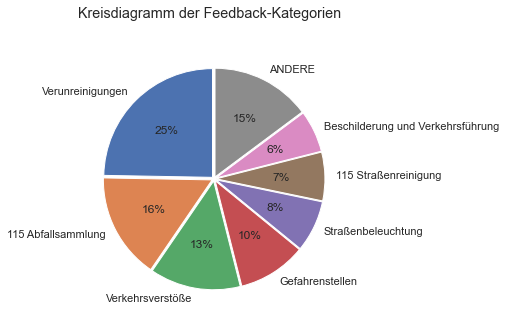

In [11]:
threshold = 0.05  # accumulate entries that occur less than 5%
freq = df['Kategorie'].value_counts(normalize=True)
mask = freq > threshold
freq_accum = freq[mask].append(pd.Series([freq[~mask].sum()],index=['ANDERE']))

title = 'Kreisdiagramm der Feedback-Kategorien'
fig, axes = plt.subplots(figsize=(5,5));
freq_accum.plot(kind='pie', autopct='%1.f%%', startangle=90, explode=[0.02]*len(freq_accum), ax=axes);
fig.suptitle(title);
axes.set_ylabel('');

The less common values, accumulated in the slice "ANDERE", are the following:

In [12]:
freq[~mask]

OA 6 Aufenthalt Nicht-EU                                 0.026348
Ampel                                                    0.025104
Beschilderung                                            0.024654
KA-Feedback Nutzerumfrage                                0.021268
Bauliche Mängel                                          0.014323
Ampeln für Fußgänger oder Radfahrer                      0.007844
115 Abfall Sperrmüll/Weiße Ware (2nd Level)              0.007567
Ampel für Kraftfahrzeuge                                 0.007032
OA 6 Terminwunsch ohne eMail-Adresse                     0.007015
OA 6 Notfalltermin (abgelaufener oder verlorener eAT)    0.002367
Pünktlichkeit des ÖPNV                                   0.002177
OA 6 EU-Bürger und EU-Familienangehörige                 0.001175
OA 6 Visumantrag Botschaft                               0.000363
Beschwerde Test                                          0.000328
Beschilderung                                            0.000276
Test      

Two categories actually contain the word 'Test':

In [13]:
test_categories = [cat for cat in df['Kategorie'].unique() if 'Test' in cat]
test_categories

['Beschwerde Test', 'Test']

How many rows would be removed upon cleaning?

In [14]:
len(df[df['Kategorie'].isin(test_categories)])

27

This is a small number so these rows can safely be removed.

**Action 4:** Drop the values 'Test' and 'Beschwerde Test' in column `Kategorie`

In [15]:
df = df[~df['Kategorie'].isin(test_categories)].reset_index(drop=True)
print(df_changes(df,'ka'))

Removed 27 rows


#### Column: `Ort`

Plot histogram of string length for the locations in `Ort`:

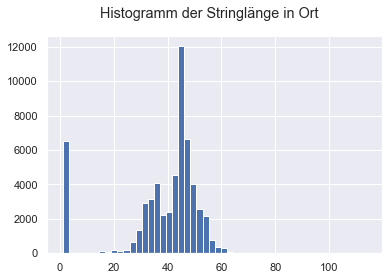

In [16]:
title = 'Histogramm der Stringlänge in Ort'
df['Ort'].apply(len).hist(bins=50, ec='white');
plt.suptitle(title);

The spike on the left shows that there are thousands of unknown addresses ("-").

For the other addresses, we can attempt to extract their postalcode.

In [17]:
def get_postalcode(location):
    """Extract 5-digit postal code from location string (returns 0 if absent)"""
    return sum([int(s) for s in location.split() if s.isdigit() and len(s)==5])

# Add postalcode
df['postalcode'] = df['Ort'].apply(get_postalcode)
print(df_changes(df,'ka'))

Added 1 column:
------------------------------------ 57853 x 1
            dtype  #NA  %NA  #unique
postalcode  int64    0    0       90
------------------------------------


From 24 thousand addresses, 90 postalcodes were extracted. 
That is still higher than we would expect to find in Karlsruhe. 
Where are these postalcodes then located? 
We can answer this by obtaining their corresponding latitude and longitude.

In [18]:
# Add longitude and latitude
col_in = 'postalcode'
cols_out = ['longitude','latitude']
nominatim = pgeocode.Nominatim('de') # Results from OpenStreetMap's geocoder Nominatim
lookup = nominatim.query_postal_code(map(str,df[col_in]))
df = df.join(lookup[cols_out])
print(df_changes(df,'ka'))

Added 2 columns:
-------------------------------------- 57853 x 2
             dtype   #NA  %NA  #unique
latitude   float64  8173   14       82
longitude  float64  8173   14       82
--------------------------------------


In [19]:
# Small correction to a few rows: set postalcode to zero (= unknown) if latitude is unknown
row_mask = df['latitude'].isna() & (df['postalcode'] > 0)
df.loc[row_mask,'postalcode'] = 0

In order to plot the locations on a map, we first need to construct a bounding box for the map. 

In [20]:
def create_bbox(lon, lat, pad=0.05):
    """Construct bounding box from a list of latitude and longitude coordinates"""
    bbox = (lon.min(), lon.max(), lat.min(), lat.max())
    width = bbox[1]-bbox[0]
    height = bbox[3]-bbox[2]
    bbox = (bbox[0]-pad*width, bbox[1]+pad*width, 
            bbox[2]-pad*height, bbox[3]+pad*height)
    return bbox
    
bbox = create_bbox(df.longitude, df.latitude)
print('Bounding box:\nx-coord: {:7.4f} < lon < {:7.4f}\ny-coord: {:7.4f} < lat < {:7.4f}'.format(*bbox))

Bounding box:
x-coord:  6.8815 < lon < 13.9341
y-coord: 47.2343 < lat < 54.4094


We then export a map with that bounding box from www.openstreetmap.org and plot the postalcodes on top of it.

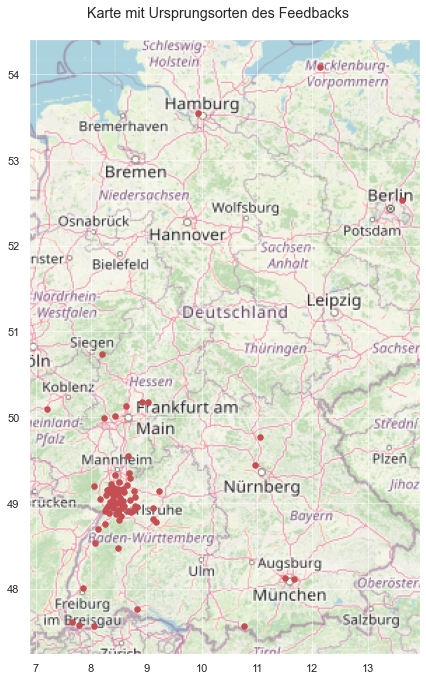

In [21]:
cols = ['longitude','latitude']
points = df[cols].value_counts()
lon,lat = map(list, zip(*points.index))

DE_map = plt.imread('data/DE_map.png')
h,w,_ = DE_map.shape

title = 'Karte mit Ursprungsorten des Feedbacks'
fig, ax = plt.subplots(figsize = (7,7*h/w))
ax.imshow(DE_map, zorder=0, extent=bbox, aspect='auto');
ax.scatter(lon, lat, zorder=1, s=30, c='r');
ax.set_xlim(bbox[0],bbox[1]);
ax.set_ylim(bbox[2],bbox[3]);
ax.grid(linewidth=0.5);
plt.suptitle(title, y=0.92);

Map data copyrighted OpenStreetMap contributors and available from https://www.openstreetmap.org

We observe that many locations of origin are in and around Karlsruhe, but there are some far away locations like Hamburg, Berlin and München. For the KA-Feedback system, these locations should be considered irrelevant. Cleaning of these datapoints can be done by computing the geographical center of all feedback, and select feedback based on their distance.

In [22]:
def great_circle_distance(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance (in km)"""
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = [lat2 - lat1, lon2 - lon1]
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2 # haversine formula
    R = 6378.137 # earch radius in km
    d = 2 * R * np.arcsin(np.sqrt(a))
    return d

# Add distance from center
cols = ['longitude','latitude']
center = df[cols].mean()
dist = df[cols].apply(lambda loc: great_circle_distance(*loc, *center), axis=1)
df['distance'] = dist
print(df_changes(df,'ka'))

Added 1 column:
------------------------------------- 57853 x 1
            dtype   #NA  %NA  #unique
distance  float64  8173   14       83
-------------------------------------


Now, let's plot a histogram of feedback distance from center.

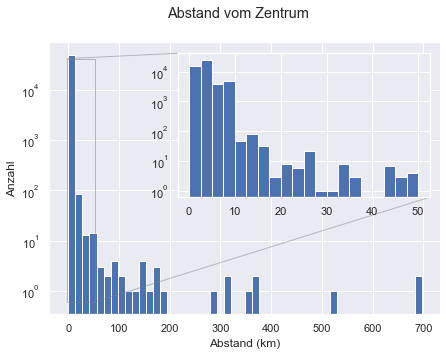

In [23]:
title = 'Abstand vom Zentrum'
fig, ax1 = plt.subplots(1, 1, figsize=(7,5))
ax1.set_xlabel('Abstand (km)')
ax1.set_ylabel('Anzahl')
ax2 = fig.add_axes([0.38, 0.45, 0.5, 0.4])
df['distance'].hist(bins=50, ax=ax1, ec='white', log=True)
df['distance'].hist(bins=20, ax=ax2, ec='white', log=True, range=(0,50));
ax1.indicate_inset_zoom(ax2);
plt.suptitle(title);

Note the logarithmic scale on the vertical axis! By far the majority of the feedback arises from within a radius of 10 kilometers, as illustrated more clearly in the following graph of the cumulative fraction of feedback as a function of radius.

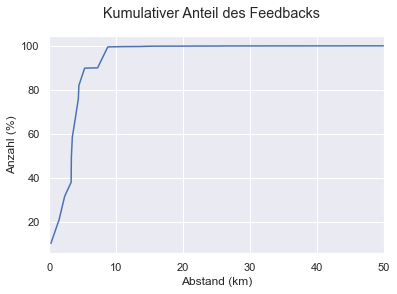

In [24]:
title = 'Kumulativer Anteil des Feedbacks'
(df['distance'].value_counts(normalize=True).multiply(100).sort_index().cumsum()
 .plot(xlim=(0,50), xlabel='Abstand (km)', ylabel='Anzahl (%)'));
plt.suptitle(title);

**Action 5:** Drop the rows with distance greater than 10 km.

In [25]:
max_dist = 10 # maximum distance in km

drop = df[df['distance'] > max_dist].index.to_list()
df = df.drop(drop).reset_index(drop=True)
print(df_changes(df,'ka'))

Removed 255 rows


We can now re-plot the feedback on a far more detailed map.

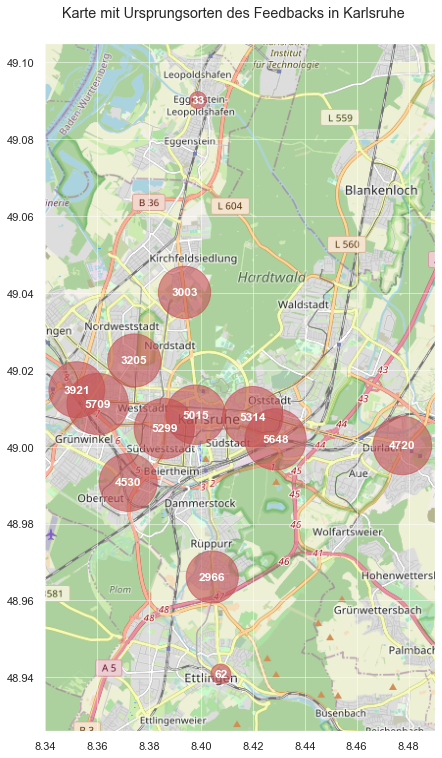

In [26]:
cols = ['latitude','longitude']
points = df[cols].value_counts()
lat,lon = map(list, zip(*points.index))
count = list(points)
size = list(50*np.sqrt(c) for c in count)
bbox = create_bbox(df.longitude, df.latitude, pad=0.1)
KA_map = plt.imread('data/KA_map.png')
h,w,_ = KA_map.shape

title = 'Karte mit Ursprungsorten des Feedbacks in Karlsruhe'
fig, ax = plt.subplots(figsize = (7,7*h/w))
ax.imshow(KA_map, zorder=0, extent=bbox, aspect='auto');
ax.scatter(lon, lat, zorder=1, alpha=0.6, s=size, c='r');
ax.set_xlim(bbox[0],bbox[1]);
ax.set_ylim(bbox[2],bbox[3]);
ax.grid(linewidth=0.5);
for lon,lat,count in zip(lon,lat,count):
    ax.annotate(str(count), xy=(lon,lat), color='white', weight='heavy', 
                horizontalalignment='center', verticalalignment='center')
plt.suptitle(title, y=0.92);

Map data copyrighted OpenStreetMap contributors and available from https://www.openstreetmap.org

#### Column: `Eingangskanal`

List the 3 unique values for `Eingangskanal`:

In [27]:
df['Eingangskanal'].value_counts()

CALL_115    26954
MOBILE      24117
WEB          6527
Name: Eingangskanal, dtype: Int64

Website usage lags behind phone and mobile. 
This makes sense, given the categories of feedback listed above, which mostly pertain situations in the public space outside on the street.
Other than that, this column looks clean. 

#### Column: `Zustand`

List the 4 unique values for `Zustand`:

In [28]:
df['Zustand'].value_counts()

Abgeschlossen    35842
Eingetroffen     10110
Behoben           9530
In Arbeit         2116
Name: Zustand, dtype: Int64

Visualise in a pie chart:

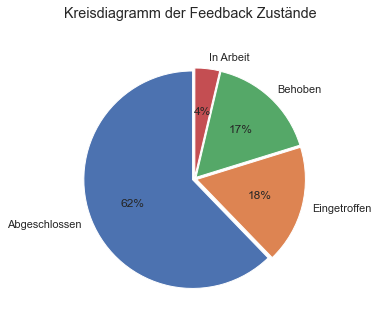

In [29]:
freq = df['Zustand'].value_counts().rename('')
title = 'Kreisdiagramm der Feedback Zustände'
fig, axes = plt.subplots(figsize=(5,5));
fig.suptitle(title);
freq.plot(kind='pie', autopct='%1.f%%', startangle=90, explode=[0.02]*len(freq), ax=axes);

These values should be interpreted as follows:  
- 'Eingetroffen': Feedback received.  
- 'In Arbeit': Feedback is being acted upon.  
- 'Behoben': Feedback was acted upon succesfully.  
- 'Abgeschlossen': Feedback closed without intervention.  

Typical Feedback-status lifecycles are:  
- 'Eingetroffen' -> 'In Arbeit' -> 'Behoben'  
- 'Eingetroffen' -> 'Abgeschlossen'

This column will be the basis for a label.

It will be interesting to see how this pie chart has changed over time. To show this, we can think of "unrolling" the above pie chart into a stacked bar chart, and subsequently plotting one such bar for each year. This gives us the following picture:

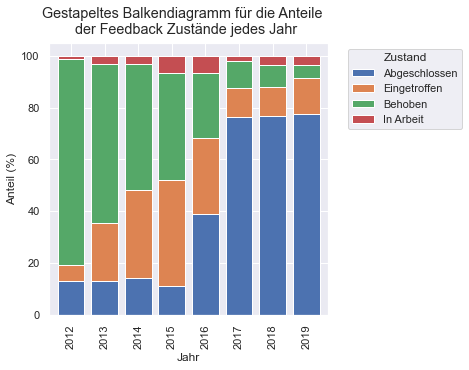

In [30]:
df['Jahr'] = df['Erstellungsdatum'].dt.year
freq_year = df['Zustand'].groupby(df['Jahr']).value_counts(normalize=True)*100
freq_year = freq_year.unstack()[freq.index]
df = df.drop('Jahr', axis=1)

title = 'Gestapeltes Balkendiagramm für die Anteile \n der Feedback Zustände jedes Jahr'
fig, axes = plt.subplots(figsize=(5,5));
fig.suptitle(title);
freq_year.plot(kind='bar', stacked=True, width=0.8, ax=axes);
axes.get_legend().set_bbox_to_anchor((1.5, 1));
axes.set_ylabel('Anteil (%)');

It seems that the relative fraction of processed feedback (in green) decreased in time.

However, these are *relative* numbers. As we will see below, the absolute numbers of feedback have simultaneously increased over the years. Let's therefore also plot the absolute numbers of each status per year:

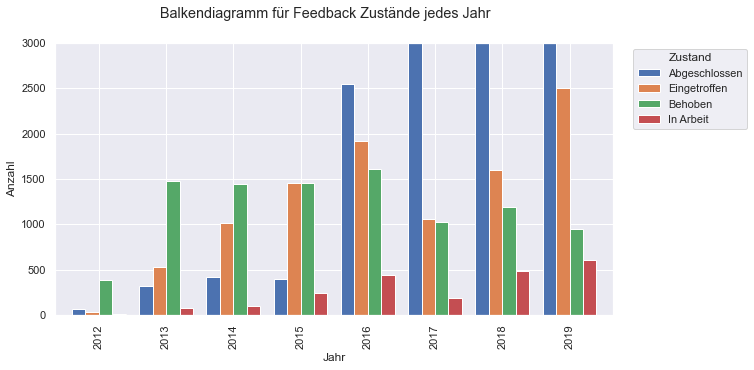

In [31]:
df['Jahr'] = df['Erstellungsdatum'].dt.year
freq_year = df['Zustand'].groupby(df['Jahr']).value_counts()
freq_year = freq_year.unstack()[freq.index]
df = df.drop('Jahr', axis=1)

title = 'Balkendiagramm für Feedback Zustände jedes Jahr'
fig, axes = plt.subplots(figsize=(10,5));
fig.suptitle(title);
freq_year.plot(kind='bar', stacked=False, width=0.8, ylim=(0,3000), ax=axes);
axes.get_legend().set_bbox_to_anchor((1.25, 1));
axes.set_ylabel('Anzahl');

This shows that the amount of feedback processed (in green) remained roughly constant in the range between 1000 and 1500 per year. The steep increase in total amount of feedback has mostly been absorbed by the unanswered closed group (in blue).

### Date columns

Plot individual distributions of year, month, day and hour:

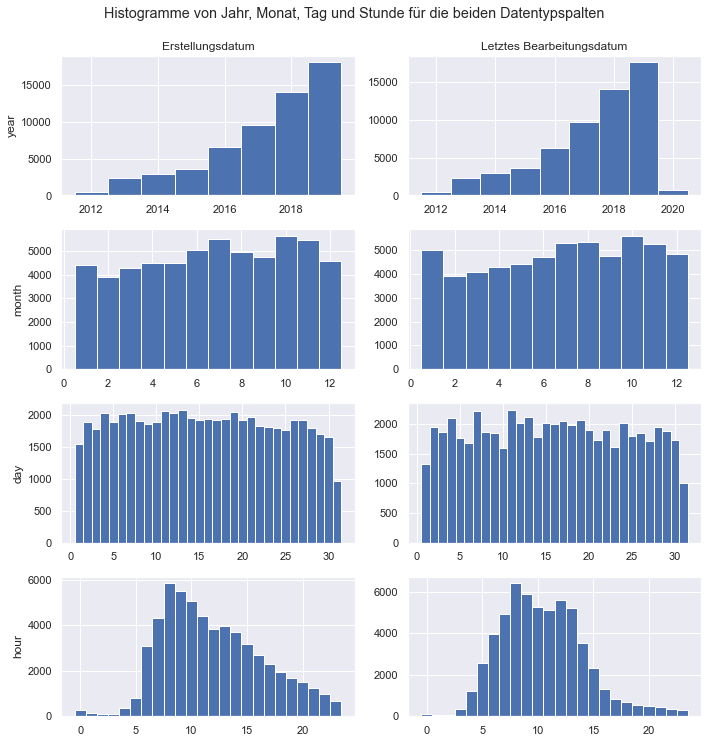

In [32]:
cols = ['Erstellungsdatum', 
        'Letztes Bearbeitungsdatum']

units = ['year', 
         'month', 
         'day', 
         'hour']

title = 'Histogramme von Jahr, Monat, Tag und Stunde für die beiden Datentypspalten'
fig, axes = plt.subplots(len(units), len(cols), figsize=(10,10))
for j,col in enumerate(cols):
    axes[0, j].set_title(col)
    for i,unit in enumerate(units):
        axes[i, 0].set_ylabel(unit)
        values = getattr(df[col].dt, unit)
        bins = list(map(lambda x: x-0.5, range(min(values),max(values)+2)))
        values.hist(bins=bins, ax=axes[i, j], ec='white');
fig.tight_layout();
fig.suptitle(title, y=1.03);

Highlight usage of the service per year:

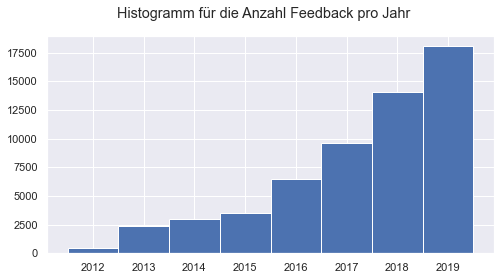

In [33]:
title = 'Histogramm für die Anzahl Feedback pro Jahr'
fig, axes = plt.subplots(figsize=(8,4))
fig.suptitle(title)
yearly = df['Erstellungsdatum'].dt.year;
bins = list(map(lambda x: x-0.5, range(min(yearly),max(yearly)+2)))
yearly.hist(bins=bins, ec='white', ax=axes);

Observations:  
1. The year histograms show a clear increase in feedback over the years  
2. The month and day histograms are rather flat: no outliers  
3. Hour of the day distribution shows most activity in the morning and gradually less during the day. 

Investigate possible correlations between different time units:
- Although month and day (of month) are flatly distributed, are there specific busy days in the year?

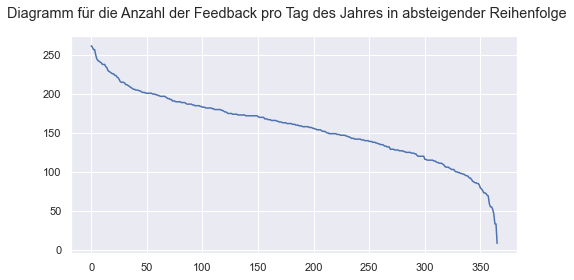

In [34]:
# Which day of the year is most feedback given?
col = 'Erstellungsdatum'
units = ['month', 'day']

copy = pd.DataFrame()
copy[units[0]] = getattr(df[col].dt, units[0])
copy[units[1]] = getattr(df[col].dt, units[1])
copy = copy.groupby(list(copy.columns)).size().reset_index(name='count')

title = 'Diagramm für die Anzahl der Feedback pro Tag des Jahres in absteigender Reihenfolge'
fig, axes = plt.subplots(figsize=(8,4))
fig.suptitle(title);
sorted_counts = copy.sort_values('count', ascending=False).reset_index(drop=True)['count']
sorted_counts.plot(ax=axes);

There are no strong outliers, as seen from this 'S'-shaped graph. 
- Busy days are quite spread out: there are about 50 days in the year with between 200 and 260 feedbacks per day.
- Quiet days are little more sparse: there are about 10 days with 50 feedbacks or less.

We can check the spread over the year with a heatmap:

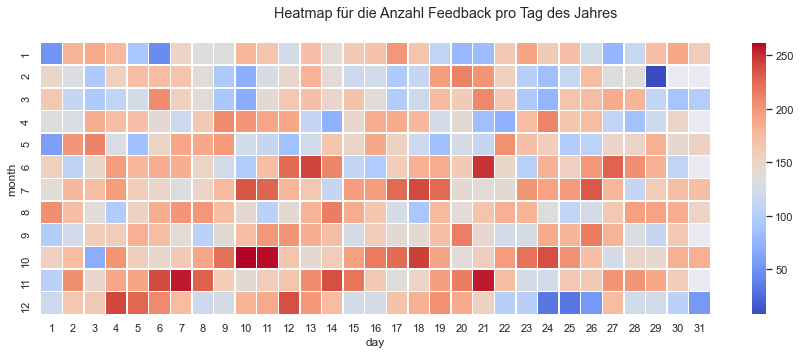

In [35]:
copy_pivot = copy.pivot(index=units[0], columns=units[1], values='count')

title = 'Heatmap für die Anzahl Feedback pro Tag des Jahres'
fig, axes = plt.subplots(figsize=(15,5))
fig.suptitle(title)
sns.heatmap(copy_pivot, linewidth=0.5, ax=axes, cmap='coolwarm');

The heatmap confirms a roughly uniform spread over the year. 
The extrema (red/blue) do not typically seem to correlate with special days. 
At most, the Christmas period (24-26 Dec) is relatively quiet.

Investigate further possible correlations between different time units:
- Are there particularly busy times in the week?

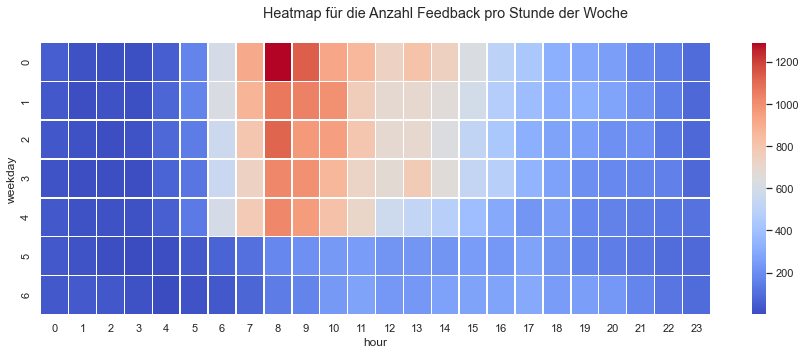

In [36]:
col = 'Erstellungsdatum'
units = ['weekday', 'hour']

copy = pd.DataFrame()
copy[units[0]] = getattr(df[col].dt, units[0])
copy[units[1]] = getattr(df[col].dt, units[1])
copy = copy.groupby(list(copy.columns)).size().reset_index(name='count')
copy = copy.pivot(index=units[0], columns=units[1], values='count')

title = 'Heatmap für die Anzahl Feedback pro Stunde der Woche'
fig, axes = plt.subplots(figsize=(15,5))
fig.suptitle(title)
sns.heatmap(copy, linewidth=0.5, ax=axes, cmap='coolwarm');

Indeed, it is particularly busy on Monday morning. The weekend is very calm, instead.

**Advice:** allocate most resources on feedback monitoring in the mornings (before lunch time) during regular working days (Mon-Fri).

## Data Export

Export the cleaned dataframe to a csv-file:

In [37]:
df = df.convert_dtypes()
df.to_csv('data/preprocessed_data.csv', index=False)
print(df_stats(df))

------------------------------------------------------------- 57598 x 10
                                    dtype   #NA  %NA  #unique
Kategorie                          string     0    0       22
Ort                                string     0    0    24091
Zustand                            string     0    0        4
Erstellungsdatum           datetime64[ns]     0    0    55125
Letztes Bearbeitungsdatum  datetime64[ns]     0    0    49433
Eingangskanal                      string     0    0        3
postalcode                          Int64     0    0       16
longitude                         float64  8173   14       13
latitude                          float64  8173   14       13
distance                          float64  8173   14       13
-------------------------------------------------------------



Check that re-import produces the same dataframe:

In [38]:
imported_df = pd.read_csv('data/preprocessed_data.csv', 
                          parse_dates=['Erstellungsdatum','Letztes Bearbeitungsdatum']
                         ).convert_dtypes()

pd.testing.assert_frame_equal(df, imported_df)